In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load MOSFET parameter and measurement data
params_df = pd.read_csv('mosfet_params_v9.csv')  
# Expected columns: MOSFET_ID, L, W, KP, VTO, LAMBDA, PHI

measurements_df = pd.read_csv('measurements_v9.csv')  
# Expected columns: MOSFET_ID, meas_index, VGS, VDS, ID

# Group measurements by MOSFET_ID, sort by meas_index, and flatten (VGS, VDS, ID) data into a vector
X_list = []
mosfet_ids = []

# Group by MOSFET_ID; assume each MOSFET has 561 measurement rows.
grouped = measurements_df.groupby('MOSFET_ID')
for mosfet_id, group in grouped:
    group_sorted = group.sort_values('meas_index')
    # Check if you have exactly 561 points
    if len(group_sorted) == 561:
        # Use VGS, VDS, and ID from each measurement.
        # The input vector will have 561 * 3 features.
        features = group_sorted[['VGS', 'VDS', 'ID']].values.flatten()
        X_list.append(features)
        mosfet_ids.append(mosfet_id)

X = np.array(X_list)  # Shape: (num_devices, 561*3)

# Prepare target parameters y (only L, W, KP, VTO since LAMBDA and PHI are constants)
params_df.set_index('MOSFET_ID', inplace=True)
y_list = []
for mosfet_id in mosfet_ids:
    row = params_df.loc[mosfet_id, ['VTO']].values
    y_list.append(row)
y = np.array(y_list).reshape(-1, 1)  # Shape: (num_devices, 1)

print("Input shape (X):", X.shape)
print("Target shape (y):", y.shape)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the inputs and outputs (a common practice for regression tasks)
input_scaler = StandardScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

output_scaler = StandardScaler()
y_train_scaled = output_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = output_scaler.transform(y_test.reshape(-1, 1))


Input shape (X): (50000, 1683)
Target shape (y): (50000, 1)


In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Delete the existing model
del model

# Clear TensorFlow session to remove old model states
K.clear_session()

# Reset any TensorFlow-related states
tf.random.set_seed(42)  # Re-seed for reproducibility


NameError: name 'model' is not defined

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Determine the input dimension from the preprocessed data
input_dim = X_train_scaled.shape[1]
print("Input dimension:", input_dim)

# Build the model; feel free to experiment with the number of layers/neurons.
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # Four outputs: L, W, KP, VTO
])

# Compile the model for regression using MSE loss
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Input dimension: 1683


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │       431,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 472,321 (1.80 MB)

 Trainable params: 472,321 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Set up early stopping callback to restore the best weights
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1634 - mae: 0.2461 - val_loss: 0.0194 - val_mae: 0.0917
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0258 - mae: 0.0981 - val_loss: 0.0125 - val_mae: 0.0657
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0219 - mae: 0.0888 - val_loss: 0.0126 - val_mae: 0.0702
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0410 - mae: 0.0992 - val_loss: 0.0208 - val_mae: 0.0791
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0216 - mae: 0.0749 - val_loss: 0.0147 - val_mae: 0.0752
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0154 - mae: 0.0762 - val_loss: 0.0247 - val_mae: 0.1022
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0142 - mae: 0.0728 - val_loss: 0.0069 - val_mae: 0.0512
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0164 - mae: 0.0723 - val_loss: 0.0135 - val_mae: 0.0731
Epoch 9/100
1000/1000 ━━━━━━━━━━

In [19]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test_scaled, y_test_scaled)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae)

# Make predictions on the test set and invert scaling to recover original parameter values
y_pred_scaled = model.predict(X_test_scaled)
y_pred = output_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Display a few predictions versus the true values




313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0021 - mae: 0.0253
Test Loss (MSE): 0.002009999006986618
Test MAE: 0.02491045743227005
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


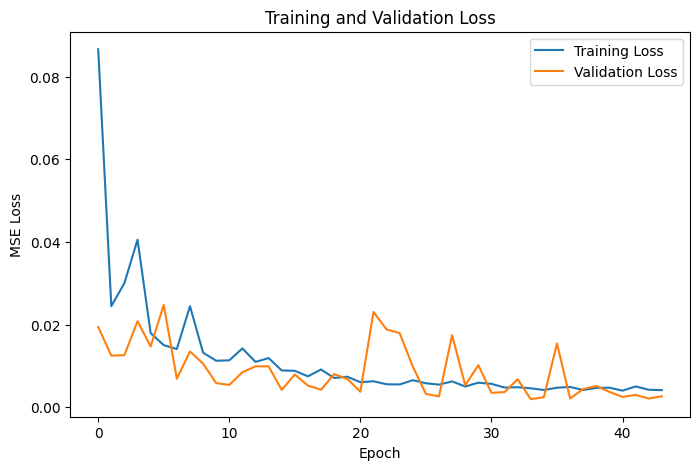

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [21]:
# Predict on the scaled test set and convert the predictions back to the original scale
predictions_scaled = model.predict(X_test_scaled)
predictions = output_scaler.inverse_transform(predictions_scaled)
y_test_original = output_scaler.inverse_transform(y_test_scaled)

# Calculate the absolute percentage error for each parameter.
# (Be sure none of the true values are zero to avoid division by zero errors.)
percentage_errors = np.abs((predictions - y_test_original) / y_test_original) * 100
mean_percentage_errors = np.mean(percentage_errors, axis=0)

# Define the parameter names (constants like LAMBDA and PHI have been removed)
parameter_names = ["VTO"]

print("\nOverall Percentage Errors:")
for i, param in enumerate(parameter_names):
    print(f"{param}: {mean_percentage_errors[i]:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Overall Percentage Errors:
VTO: 0.88%


In [15]:
# Save the model
model.save('mosfet_VTO_model_v9.keras')

In [26]:
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

# R2 Score
r2 = r2_score(y_test_original, predictions)
print(f"R² Score: {r2:.5f}")

# Mean Squared Error
mse = mean_squared_error(y_test_original, predictions)
print(f"MSE: {mse:.5f}")

# Root Mean Squared Error
rmse = root_mean_squared_error(y_test_original, predictions)
print(f"RMSE: {rmse:.5f}")


R² Score: 0.99801
MSE: 0.00014
RMSE: 0.01163
